## Visualizing MPII human joints

This jupyter notebook contains code to visualize joints ground truth overlayed on MPII human pose images. <br>
Since MPII annotations exist only for sufficiently separated humans, not all humans in the images have annotations. <br>
The code snippet can also be used to understand how the MPII matlab structure file is read in Python. <br>

Packages required: ```numpy, matplotlib, scipy, adjustText, tqdm```

Pre-requisites: <br>
Download MPII images from ```http://human-pose.mpi-inf.mpg.de/#download``` and paste all images ```*.jpg``` in the ```data/mpii/images``` folder. 



In [3]:
import os
import sys
import copy
from pathlib import Path

import scipy.io
import numpy as np
from tqdm import tqdm
from adjustText import adjust_text
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

Load the text file containing all the image names in the MPII dataset.

In [4]:
root = Path(os.getcwd())  # Fix: use current working directory
sys.path.append(str(root))

dataset_name = ['mpii']
dataset_path = list(map(lambda x: os.path.join(root, 'data', x), dataset_name))

# Format of filenames = [[mpii_img_1, mpii_img_2, ... (mpii_img_k)]]
filenames_ = list(map(lambda path, name: open(os.path.join(path, '{}_filenames.txt'.format(name))), dataset_path, dataset_name))
filenames = list(map(lambda f: f.read().split(), filenames_))
_ = list(map(lambda f: f.close(), filenames_))

#### Declaring the function for visualizing image and joints

We color code the joints corresponding to the {right, left} + {leg, arm} and the face. <br>
A directory is created to dump the images: ```./results/viz_gt/*.jpg``` <br>
We then iterate over all: ```{image [i], persons [k] in image [i], joint [j] for person [k]}```

In [5]:
def visualize_image(image_info):
    '''
    :param image_info: (dict)
    '''
    colour = {'rankl': (0, 0, 1), 'rknee': (0, 0, 1), 'rhip': (0, 0, 1),
              'lankl': (1, 0, 0), 'lknee': (1, 0, 0), 'lhip': (1, 0, 0),
              'rwri': (1, 1, 0), 'relb': (1, 1, 0), 'rsho': (1, 1, 0),
              'lwri': (0, 1, 0), 'lelb': (0, 1, 0), 'lsho': (0, 1, 0),
              'head': (0, 1, 1), 'thorax': (0, 1, 1), 'upper_neck': (0, 1, 1)}

    os.makedirs(os.path.join(root, 'results', 'viz_gt'), exist_ok=True)
    img_dump = os.path.join(root, 'results', 'viz_gt')

    # Since we're considering only MPII, the outer loop will execute only once.
    for dataset_name_ in image_info.keys():
        # Iterate over all images
        for i in tqdm(range(len(image_info[dataset_name_]['img']))):

            fig, ax = plt.subplots(nrows=1, ncols=1, frameon=False)
            ax.set_axis_off()

            # Load image, gt for the given index
            img = image_info[dataset_name_]['img'][i]
            img_name = image_info[dataset_name_]['img_name'][i]
            img_gt = image_info[dataset_name_]['img_gt'][i]

            # Store joint names which will be displayed on the image
            text_overlay = []
            ax.imshow(img)

            # Color-code the joint and joint name onto the image
            joint_names = list(colour.keys())
            for jnt in joint_names:
                for jnt_gt in img_gt[jnt]:
                    if jnt_gt[2]:
                        text_overlay.append(ax.text(x=jnt_gt[0], y=jnt_gt[1], s=jnt, color=colour[jnt], fontsize=6))
                        ax.add_patch(Circle(jnt_gt[:2], radius=1.5, color=colour[jnt], fill=False))

            # Ensure no crowding of joints on the image
            adjust_text(text_overlay)

            plt.savefig(fname=os.path.join(img_dump, '{}'.format(img_name)),
                        facecolor='black', edgecolor='black', bbox_inches='tight', dpi=300)

            plt.close()
            del fig, ax

#### Preparing the images and ground truth 

The index to joint name conversion is provided on MPII website. <br>
We load ```batch = 200``` images at a time to prevent exhausting available RAM. <br>
The subsequent ```for``` loop(s) are used to unravel the matlab structure file to obtain the joint ground truths.

In [6]:
# index to joint name conversion
mpii_idx_to_jnt = {0: 'rankl', 1: 'rknee', 2: 'rhip', 5: 'lankl', 4: 'lknee', 3: 'lhip',
                   6: 'pelvis', 7: 'thorax', 8: 'upper_neck', 11: 'relb', 10: 'rwri', 9: 'head',
                   12: 'rsho', 13: 'lsho', 14: 'lelb', 15: 'lwri'}

# This template will then be updated as and when we read ground truth
mpii_template = dict([(mpii_idx_to_jnt[i], []) for i in range(16)])

# Load the mat file.
matlab_mpii = scipy.io.loadmat(os.path.join(dataset_path[0], 'mpii_annotations.mat'), struct_as_record=False)['RELEASE'][0, 0]
#num_images = annotation_mpii = matlab_mpii.__dict__['annolist'][0].shape[0]
num_images = 10

# Load images and GT in batches of 200
initial_index = 0
batch = 200
while initial_index < num_images:
    # Initialize empty placeholder
    img_dict = {'mpii': {'img': [], 'img_name': [], 'img_pred': [], 'img_gt': []}}

    # Iterate over each image
    for img_idx in tqdm(range(initial_index, min(initial_index + batch, num_images))):
        annotation_mpii = matlab_mpii.__dict__['annolist'][0, img_idx]
        train_test_mpii = matlab_mpii.__dict__['img_train'][0, img_idx].flatten()[0]
        person_id = matlab_mpii.__dict__['single_person'][img_idx][0].flatten()

        # Load the individual image. Throw an exception if image corresponding to filename not available.
        img_name = annotation_mpii.__dict__['image'][0, 0].__dict__['name'][0]
        try:
            image = plt.imread(os.path.join(dataset_path[0], 'images', img_name))
        except FileNotFoundError:
            print('Could not load filename: {}'.format(img_name))
            continue

        # Avoid modifying the template and create a copy
        gt_per_image = copy.deepcopy(mpii_template)

        # Flag is set to true if atleast one person exists in the image with joint annotations.
        # If Flag == True, then the image and GT is considered for visualization, else skip
        annotated_person_flag = False

        # Iterate over persons
        for person in (person_id - 1):
            try:
                annopoints_img_mpii = annotation_mpii.__dict__['annorect'][0, person].__dict__['annopoints'][0, 0]
                num_joints = annopoints_img_mpii.__dict__['point'][0].shape[0]

                # Iterate over present joints
                for i in range(num_joints):
                    x = annopoints_img_mpii.__dict__['point'][0, i].__dict__['x'].flatten()[0]
                    y = annopoints_img_mpii.__dict__['point'][0, i].__dict__['y'].flatten()[0]
                    id_ = annopoints_img_mpii.__dict__['point'][0, i].__dict__['id'][0][0]
                    vis = annopoints_img_mpii.__dict__['point'][0, i].__dict__['is_visible'].flatten()

                    # No entry corresponding to visible
                    if vis.size == 0:
                        vis = 1
                    else:
                        vis = vis.item()

                    gt_per_joint = np.array([x, y, vis]).astype(np.float16)
                    gt_per_image[mpii_idx_to_jnt[id_]].append(gt_per_joint)

                annotated_person_flag = True
            except KeyError:
                # Person 'x' could not have annotated joints, hence move to person 'y'
                continue

        if not annotated_person_flag:
            continue

        # Update the template copy with image, name and ground truth
        img_dict['mpii']['img'].append(image)
        img_dict['mpii']['img_name'].append(img_name)
        img_dict['mpii']['img_gt'].append(gt_per_image)

    visualize_image(img_dict)
    initial_index += batch

100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

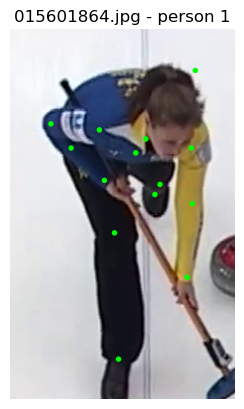

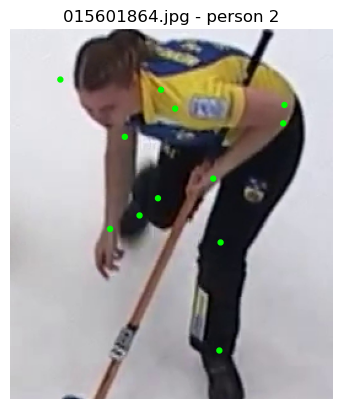

 50%|█████     | 5/10 [00:00<00:00, 16.82it/s]

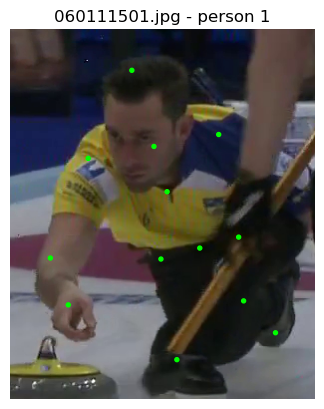

100%|██████████| 10/10 [00:00<00:00, 19.99it/s]


In [35]:
import cv2

def crop_person(image, joints, margin=40):
    # Get all visible joint coordinates
    coords = np.array([[j[0], j[1]] for j in joints if j[2] > 0])
    if len(coords) == 0:
        return None, None
    x_min, y_min = coords.min(axis=0) - margin
    x_max, y_max = coords.max(axis=0) + margin
    x_min, y_min = max(0, int(x_min)), max(0, int(y_min))
    x_max, y_max = min(image.shape[1], int(x_max)), min(image.shape[0], int(y_max))
    cropped = image[y_min:y_max, x_min:x_max]
    # Adjust joints to new crop
    new_joints = []
    for j in joints:
        if j[2] > 0:
            new_joints.append([j[0]-x_min, j[1]-y_min, j[2]])
    return cropped, new_joints

def show_single_person_images(matlab_mpii, dataset_path, idx_to_jnt, max_images=10):
    annolist = matlab_mpii.__dict__['annolist'][0]
    single_person = matlab_mpii.__dict__['single_person']
    for img_idx in tqdm(range(min(max_images, len(annolist)))):
        annotation = annolist[img_idx]
        img_name = annotation.__dict__['image'][0, 0].__dict__['name'][0]
        img_path = os.path.join(dataset_path[0], 'images', img_name)
        if not os.path.exists(img_path):
            continue
        image = plt.imread(img_path)
        person_ids = single_person[img_idx][0].flatten()
        for pidx, person in enumerate(person_ids - 1):
            try:
                annopoints = annotation.__dict__['annorect'][0, person].__dict__['annopoints'][0, 0]
                points = annopoints.__dict__['point'][0]
                # Gather all joints for this person
                joints = []
                for i in range(points.shape[0]):
                    x = points[i].__dict__['x'].flatten()[0]
                    y = points[i].__dict__['y'].flatten()[0]
                    id_ = points[i].__dict__['id'][0][0]
                    vis = points[i].__dict__['is_visible'].flatten()
                    vis = vis.item() if vis.size > 0 else 1
                    joints.append([x, y, vis])
                cropped_img, cropped_joints = crop_person(image, joints)
                if cropped_img is None:
                    continue
                # Plot
                fig, ax = plt.subplots()
                ax.imshow(cropped_img)
                for j in cropped_joints:
                    ax.add_patch(Circle((j[0], j[1]), radius=2, color='lime', fill=True))
                ax.set_title(f"{img_name} - person {pidx+1}")
                ax.axis('off')
                plt.show()
                plt.close(fig)
            except Exception as e:
                continue

# Usage:
show_single_person_images(matlab_mpii, dataset_path, mpii_idx_to_jnt, max_images=10)

  0%|          | 0/24987 [00:00<?, ?it/s]

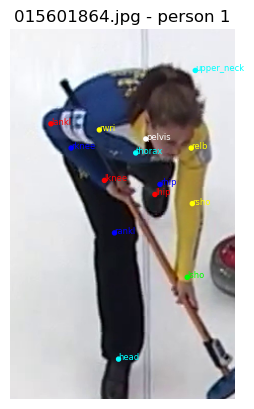

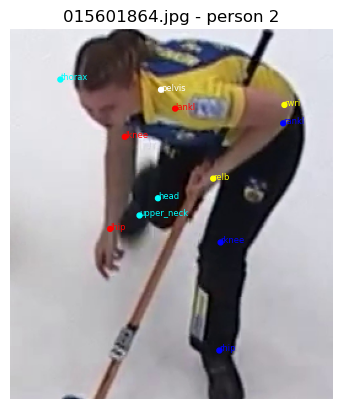

  0%|          | 5/24987 [00:00<25:40, 16.22it/s]

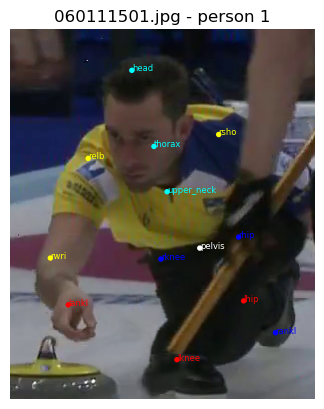

  0%|          | 9/24987 [00:00<22:01, 18.91it/s]

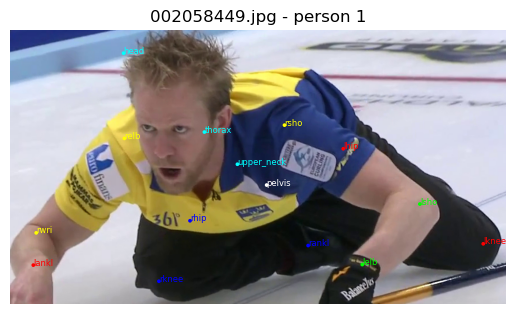

  0%|          | 11/24987 [00:00<24:17, 17.14it/s]

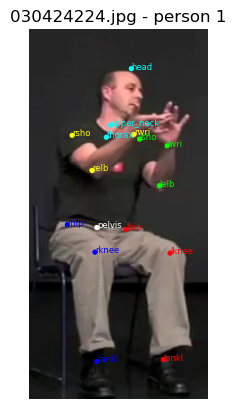

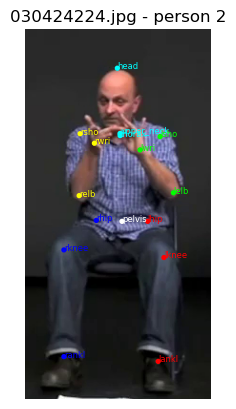

  0%|          | 17/24987 [00:00<17:36, 23.63it/s]

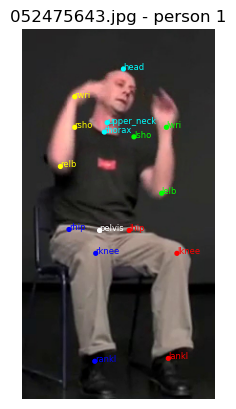

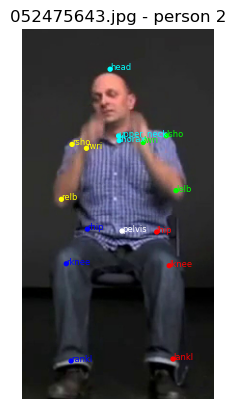

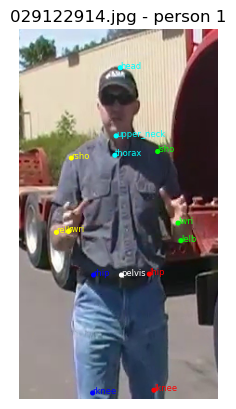

  0%|          | 20/24987 [00:01<22:40, 18.35it/s]

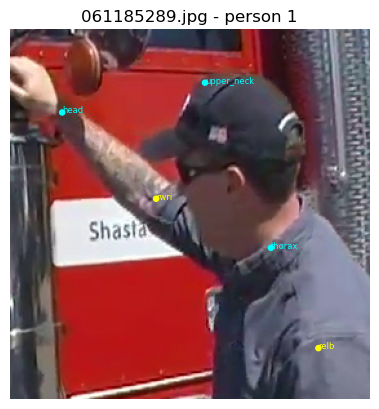

  0%|          | 21/24987 [00:01<23:06, 18.00it/s]


In [38]:
def show_single_person_images(matlab_mpii, dataset_path, idx_to_jnt, max_images=10):
    # Joint color coding as in visualize_image
    colour = {
        'rankl': (0, 0, 1), 'rknee': (0, 0, 1), 'rhip': (0, 0, 1),
        'lankl': (1, 0, 0), 'lknee': (1, 0, 0), 'lhip': (1, 0, 0),
        'rwri': (1, 1, 0), 'relb': (1, 1, 0), 'rsho': (1, 1, 0),
        'lwri': (0, 1, 0), 'lelb': (0, 1, 0), 'lsho': (0, 1, 0),
        'head': (0, 1, 1), 'thorax': (0, 1, 1), 'upper_neck': (0, 1, 1)
    }
    annolist = matlab_mpii.__dict__['annolist'][0]
    single_person = matlab_mpii.__dict__['single_person']
    shown = 0
    for img_idx in tqdm(range(len(annolist))):
        if shown >= max_images:
            break
        annotation = annolist[img_idx]
        img_name = annotation.__dict__['image'][0, 0].__dict__['name'][0]
        img_path = os.path.join(dataset_path[0], 'images', img_name)
        if not os.path.exists(img_path):
            continue
        image = plt.imread(img_path)
        person_ids = single_person[img_idx][0].flatten()
        for pidx, person in enumerate(person_ids - 1):
            try:
                annopoints = annotation.__dict__['annorect'][0, person].__dict__['annopoints'][0, 0]
                points = annopoints.__dict__['point'][0]
                # Gather all joints for this person
                joints = []
                joint_names = []
                for i in range(points.shape[0]):
                    x = points[i].__dict__['x'].flatten()[0]
                    y = points[i].__dict__['y'].flatten()[0]
                    id_ = points[i].__dict__['id'][0][0]
                    vis = points[i].__dict__['is_visible'].flatten()
                    vis = vis.item() if vis.size > 0 else 1
                    joints.append([x, y, vis])
                    joint_names.append(idx_to_jnt.get(id_, 'unknown'))
                cropped_img, cropped_joints = crop_person(image, joints)
                if cropped_img is None:
                    continue
                # Plot with color coding, do not save
                fig, ax = plt.subplots()
                ax.imshow(cropped_img)
                for j, name in zip(cropped_joints, joint_names):
                    color = colour.get(name, (1, 1, 1))  # default to white if unknown
                    if j[2]:
                        ax.add_patch(Circle((j[0], j[1]), radius=2, color=color, fill=True))
                        ax.text(j[0], j[1], name, color=color, fontsize=6)
                ax.set_title(f"{img_name} - person {pidx+1}")
                ax.axis('off')
                plt.show()
                plt.close(fig)
                shown += 1
                if shown >= max_images:
                    break
            except Exception:
                continue

# Usage:
show_single_person_images(matlab_mpii, dataset_path, mpii_idx_to_jnt, max_images=10)

In [11]:
import os
import json
from matplotlib.patches import Circle
from tqdm import tqdm

def crop_person(image, joints, margin=40):
    # Get all visible joint coordinates
    coords = np.array([[j[0], j[1]] for j in joints if j[2] > 0])
    if len(coords) == 0:
        return None, None
    x_min, y_min = coords.min(axis=0) - margin
    x_max, y_max = coords.max(axis=0) + margin
    x_min, y_min = max(0, int(x_min)), max(0, int(y_min))
    x_max, y_max = min(image.shape[1], int(x_max)), min(image.shape[0], int(y_max))
    cropped = image[y_min:y_max, x_min:x_max]
    # Adjust joints to new crop
    new_joints = []
    for j in joints:
        if j[2] > 0:
            new_joints.append([j[0]-x_min, j[1]-y_min, j[2]])
    return cropped, new_joints

def save_single_person_crops_and_annotations(matlab_mpii, dataset_path, idx_to_jnt, out_dir='cropped_persons', ann_file='cropped_persons_annotations.json', max_images=1000):
    import matplotlib.pyplot as plt
    os.makedirs(out_dir, exist_ok=True)
    annolist = matlab_mpii.__dict__['annolist'][0]
    single_person = matlab_mpii.__dict__['single_person']
    annotations = []
    saved = 0

    for img_idx in tqdm(range(len(annolist))):
        if saved >= max_images:
            break
        annotation = annolist[img_idx]
        img_name = annotation.__dict__['image'][0, 0].__dict__['name'][0]
        img_path = os.path.join(dataset_path[0], 'images', img_name)
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue
        image = plt.imread(img_path)
        person_ids = single_person[img_idx][0].flatten()
        for pidx, person in enumerate(person_ids - 1):
            try:
                annopoints = annotation.__dict__['annorect'][0, person].__dict__['annopoints'][0, 0]
                points = annopoints.__dict__['point'][0]
                joints = []
                joint_names = []
                for i in range(points.shape[0]):
                    x = points[i].__dict__['x'].flatten()[0]
                    y = points[i].__dict__['y'].flatten()[0]
                    id_ = points[i].__dict__['id'][0][0]
                    vis = points[i].__dict__['is_visible'].flatten()
                    vis = vis.item() if vis.size > 0 else 1
                    joints.append([float(x), float(y), int(vis), int(id_)])
                    joint_names.append(idx_to_jnt.get(id_, 'unknown'))
                cropped_img, cropped_joints = crop_person(image, joints)
                if cropped_img is None:
                    print(f"No visible joints for {img_name} person {pidx+1}")
                    continue
                # Save cropped image
                out_img_name = f"{os.path.splitext(img_name)[0]}_person{pidx+1}.jpg"
                out_img_path = os.path.join(out_dir, out_img_name)
                plt.imsave(out_img_path, cropped_img)
                print(f"Saved: {out_img_path}")
                # Prepare annotation entry
                annotation_entry = {
                    "image": out_img_name,
                    "original_image": img_name,
                    "person_index": int(pidx+1),
                    "joints": [
                        {
                            "name": name,
                            "x": float(j[0]),
                            "y": float(j[1]),
                            "visible": int(j[2]),
                            "mpii_id": int(j[3])
                        }
                        for j, name in zip(joints, joint_names)
                    ]
                }
                annotations.append(annotation_entry)
                saved += 1
                if saved >= max_images:
                    break
            except Exception as e:
                print(f"Exception for {img_name} person {pidx+1}: {e}")
                continue

    # Save all annotations to a JSON file
    with open(ann_file, 'w') as f:
        json.dump(annotations, f, indent=2)
    print(f"Saved {saved} cropped images and annotations to {out_dir} and {ann_file}")

# Usage:
save_single_person_crops_and_annotations(
    matlab_mpii, dataset_path, mpii_idx_to_jnt,
    out_dir='cropped_persons',
    ann_file='cropped_persons_annotations.json',
    max_images=5
)

  0%|          | 0/24987 [00:00<?, ?it/s]

  0%|          | 11/24987 [00:00<06:03, 68.62it/s]

Exception for 037454012.jpg person 1: 'annopoints'
Exception for 073199394.jpg person 1: 'annopoints'
Exception for 059865848.jpg person 1: 'annopoints'
Saved: cropped_persons/015601864_person1.jpg
Saved: cropped_persons/015601864_person2.jpg
Saved: cropped_persons/015599452_person1.jpg
Saved: cropped_persons/060111501_person1.jpg
Saved: cropped_persons/002058449_person1.jpg
Saved 5 cropped images and annotations to cropped_persons and cropped_persons_annotations.json
